<strong>Abstract</strong>  
In this notebook, convolutional neural networks will be build to classify cats and dogs. You will see how to build convolutional neural networks, implement data augmentation, do feature extraction, and perform fine-tuning. 

<strong>Reference</strong>  
See pages 130-159 of "<strong>Deep Learning with Python</strong>" by Francois Chollet (2018). 

<strong>Summary (page 159)</strong>  
- Data augmentation is a powerful method to avoid overfitting when working with image data.
- You can reuse an existing convolutional neural networks on a new dataset via feature extraction.
- As a complement to feature extraction, you can use fine-tuning.

# Data preparation

In order to create a folder for storing images on Google Drive, Google Colab should be connected with Google Drive. After running the next cell, you will be asked to enter your authorization code. You can do it simply by copy-and-paste.

In [34]:
from google import colab
colab.drive.mount('/content/gdrive')
!ls 'gdrive/My Drive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ls: cannot access 'gdrive/My Drive': No such file or directory


In the next cell, a directory where you want to create a folder "cats_and_dogs" will be specified. All images will be stored in this folder.

In [35]:
import os 

path = '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning_with_Python_Chollet' # specify your directory where you want to create a folder for storing data.
os.chdir(path) # change directory.

new_folder_name='cats_and_dogs' # create a folder for storing data.

if not os.path.exists(new_folder_name): # create a folder for storing data if it does not exist.
    os.mkdir(new_folder_name) # make a directory

os.chdir(path + '/' + new_folder_name) # change directory

print("Current directory:", os.getcwd())

Current directory: /content/gdrive/My Drive/Colab Notebooks/Deep_Learning_with_Python_Chollet/cats_and_dogs


Using Kaggle API, it is possible to download data from Kaggle Competitions. In order to do that, you have to create API token. If you do not have one yet, you can create it from your account page of Kaggle. After you create it, you get kaggle.json. In the next cell, please upload this json file.

In [0]:
# you do not have to run this cell twice.

from google.colab import files
files.upload() # appload kaggle,json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kotarosonoda","key":"b53a8fa55dffd332fc66c27761282e40"}'}

Running the next cell starts downloading zip files from Kaggle competition page.

In [0]:
# you do not have to run this cell twice.

!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Let us check whether we have succeeded in downloading zip files. 

In [0]:
# you do not have to run this cell twice.

zipfiles = glob.glob(os.getcwd() + '/*.zip')
zipfiles

['/content/gdrive/My Drive/Colab Notebooks/Deep_Learning_with_Python_Chollet/cats_and_dogs/train.zip',
 '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning_with_Python_Chollet/cats_and_dogs/test1.zip']

The contents of the .zip are extracted to the current directory after running the next cell. It will take some time because of a large dataset. At first, a training dataset will be unzipped.

In [0]:
# you do not have to run this cell twice.

import zipfile

local_zip =zipfiles[0] # specify where train.zip is
zip_ref = zipfile.ZipFile(local_zip, 'r')  # create a ZipFile object
zip_ref.extractall() # create a folder in the current directory and get all data
zip_ref.close() # close

The number of training images is 25000, which consists of 12500 cat pictures and 12500 dog pictures.

In [0]:
# you do not have to run this cell twice.

import glob

print("The number of training data:", len(glob.glob(os.getcwd() + '/train/*')) )
print("Cat pictures:", len(glob.glob(os.getcwd() + '/train/cat*')) )
print("Dog pictures:", len(glob.glob(os.getcwd() + '/train/dog*')) )

The number of training data: 25000
Cat pictures: 12500
Dog pictures: 12500


Next, a test dataset will be unzipped.

In [0]:
# you do not have to run this cell twice.

import zipfile

local_zip =zipfiles[1] # specify where test1.zip is
zip_ref = zipfile.ZipFile(local_zip, 'r')  # create a ZipFile object
zip_ref.extractall() # create a folder in the current directory and get all data
zip_ref.close() # close

In [0]:
# you do not have to run this cell twice.

print("The number of test images:", len(glob.glob(os.getcwd() + '/test1/*.jpg')))

The number of test images: 12500


A function for visualizing a picture is defined and used in the next cell.

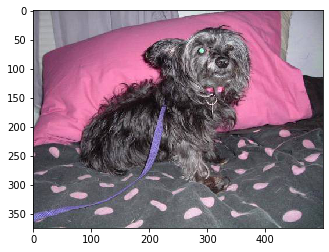

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def simpleVisualization(filename,reshape_size): # function for visualizing a pitcure. Returns numpy array
  # Examples: filename = 'dog.1'   filename = 'cat.1'
  #If you do not want to reshape the figure, set reshape_size=-1

    datpath = '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning_with_Python_Chollet/cats_and_dogs/train'
    image_file = os.path.join( datpath,  filename + '.jpg')
  
    im = Image.open(image_file)
    
    if reshape_size == -1:
        img = np.asarray(im)
    else:
        img = im.resize((reshape_size,reshape_size))
        img = np.asarray(img)

    plt.imshow(img)
 
    return img

img = simpleVisualization('dog.0',-1)

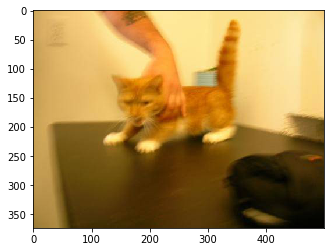

In [37]:
img = simpleVisualization('cat.0',-1)

In the folder "train," two folders called "partial_train" and "validation" will be created after running next two cells. In these folders, partial training set and validation set will be prepared by splitting the original training set. In each folder, two folders named "cat" and "dog" will be made. The purpose of making these subdirectories is to automatically label images using an <strong>[ImageGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class)</strong>. 

In [0]:
datpath= '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning_with_Python_Chollet/cats_and_dogs' 
datpath_train = os.path.join(datpath, 'train')

os.chdir(datpath_train)

datpath_partial_train = os.path.join(datpath_train, 'partial_train') 
datpath_validation = os.path.join(datpath_train, 'validation')

datpath_partial_train_cat = os.path.join(datpath_partial_train, 'cat')
datpath_partial_train_dog = os.path.join(datpath_partial_train, 'dog')

datpath_validation_cat = os.path.join(datpath_validation, 'cat')
datpath_validation_dog = os.path.join(datpath_validation, 'dog')

# make folders if they do not exist
if not os.path.exists(datpath_partial_train):
  os.mkdir(datpath_partial_train)
if not os.path.exists(datpath_validation):
  os.mkdir(datpath_validation)
if not os.path.exists(datpath_partial_train_cat):
  os.mkdir(datpath_partial_train_cat)
if not os.path.exists(datpath_partial_train_dog):
  os.mkdir(datpath_partial_train_dog)
if not os.path.exists(datpath_validation_cat):
  os.mkdir(datpath_validation_cat)
if not os.path.exists(datpath_validation_dog):
  os.mkdir(datpath_validation_dog)

num_training_data_cat = 1000
num_training_data_dog = 1000 

num_validation_data_cat = 500
num_validation_data_dog = 500 

num_test_data_cat = 50 
num_test_data_dog = 50 

In [0]:
# you do not have to run this cell twice.

import shutil 

# PARTIAL TRAINING SET
# Copy cat images in the training set to /partial_train/cat directory. 
fnames = ['cat.{}.jpg'.format(i) for i in range(num_training_data_cat)]
for fname in fnames:
  src = os.path.join(datpath_train, fname)
  dst = os.path.join(datpath_partial_train_cat, fname)
  shutil.copyfile(src, dst)

# Copy dog images in the training set to /partial_train/dog directory. 
fnames = ['dog.{}.jpg'.format(i) for i in range(num_training_data_dog)]
for fname in fnames:
  src = os.path.join(datpath_train, fname)
  dst = os.path.join(datpath_partial_train_dog, fname)
  shutil.copyfile(src, dst)
# END OF PARTIAL TRAINING SET

# VALIDATION SET
# Copy cat images in the training set to /validation/cat directory. 
fnames = ['cat.{}.jpg'.format(i) for i in range(num_training_data_cat, num_training_data_cat + num_validation_data_cat)]
for fname in fnames:
  src = os.path.join(datpath_train, fname)
  dst = os.path.join(datpath_validation_cat, fname)
  shutil.copyfile(src, dst)

# Copy dog images in the training set to /validation/dog directory. 
fnames = ['dog.{}.jpg'.format(i) for i in range(num_training_data_dog, num_training_data_dog + num_validation_data_dog)]
for fname in fnames:
  src = os.path.join(datpath_train, fname)
  dst = os.path.join(datpath_validation_dog, fname)
  shutil.copyfile(src, dst)
# END OF VALIDATION SET

In [0]:
# you do not have to run this cell twice.

print("Partial training cat images: ", len(os.listdir(datpath_partial_train_cat)))
print("Partial training dog images: ", len(os.listdir(datpath_partial_train_dog)))
print("Validation cat images: ",len(os.listdir(datpath_validation_cat)))
print("Validation dog images: ", len(os.listdir(datpath_validation_dog)))

Partial training cat images:  1000
Partial training dog images:  1000
Validation cat images:  500
Validation dog images:  500


In [39]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20
target_size = (150,150)


train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    datpath_partial_train,
    target_size = target_size, 
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    datpath_validation,
    target_size = target_size,
    batch_size=batch_size,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In the previous cell, the image generators are created. As a next step, let us check the output of one of these generators. In the previous cell, you set the following parameters: 
- batch_size = 20
- target_size = (150,150)   

With this setting, the data batch shape is (20, 150, 150, 3). The first number 20 is the batch size. The second, third, and forth numbers are height, width, and depth of an image, respectively. Everytime you run the next cell, you get different labels and images. 

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)
label: [0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


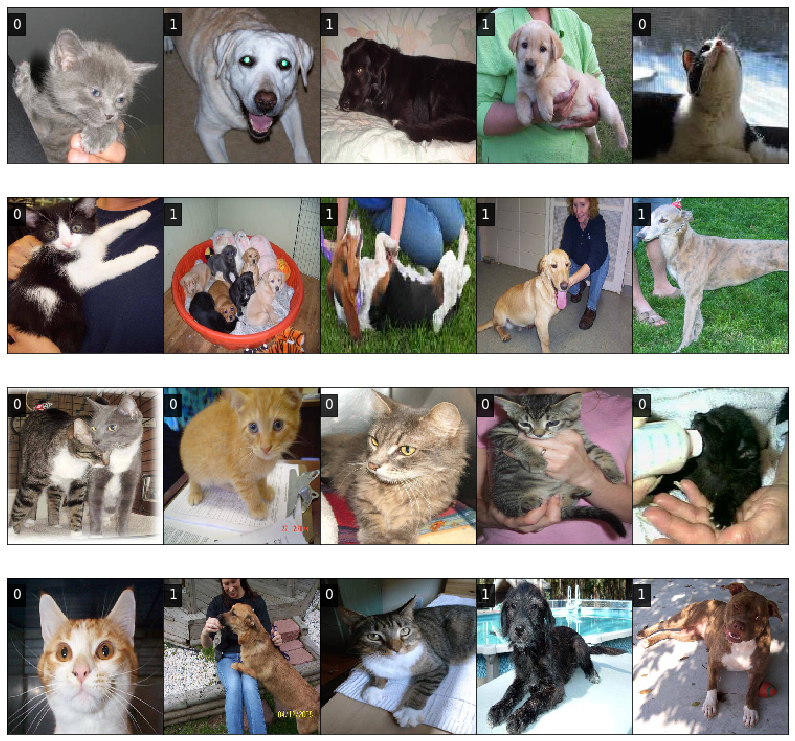

In [40]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  print('label:', labels_batch)
  break

plt.figure(figsize = (14,14))
for j in range(20):
  plt.subplot(4,5,j+1)
  plt.imshow(data_batch[j])
  plt.text(4,20,'%d'%labels_batch[j], color='white', fontsize=14, bbox=dict(facecolor='black',alpha=0.8))
  plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Training a convolutional neural network

In [0]:
from keras import layers 
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)  

[fit_generator](https://keras.io/models/sequential/#fit_generator)

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
)

model.save('model1_without_augmentation_and_dropout.h5')

Epoch 1/30
100/100 [==============================] - 396s 4s/step - loss: 0.6526 - acc: 0.6160 - val_loss: 0.6369 - val_acc: 0.6430
Epoch 2/30
100/100 [==============================] - 17s 171ms/step - loss: 0.6050 - acc: 0.6755 - val_loss: 0.6278 - val_acc: 0.6390
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.5559 - acc: 0.7155 - val_loss: 0.6337 - val_acc: 0.6420
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.5271 - acc: 0.7325 - val_loss: 0.5942 - val_acc: 0.6790
Epoch 5/30
100/100 [==============================] - 17s 169ms/step - loss: 0.4994 - acc: 0.7495 - val_loss: 0.5948 - val_acc: 0.6720
Epoch 6/30
100/100 [==============================] - 17s 172ms/step - loss: 0.4691 - acc: 0.7780 - val_loss: 0.6387 - val_acc: 0.6610
Epoch 7/30
100/100 [==============================] - 17s 171ms/step - loss: 0.4528 - acc: 0.7840 - val_loss: 0.5612 - val_acc: 0.7090
Epoch 8/30
100/100 [==============================] - 17s

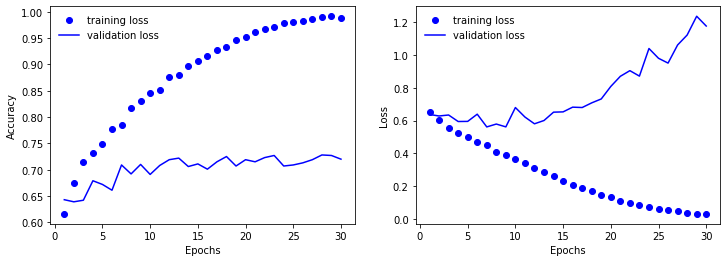

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label = 'training loss')
plt.plot(epochs, val_acc, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()

In the present case, only 2000 images are used for training a model. As a result, the contribution of the overfitting is clearly seen.

# Data augmentation (from page 138)

Data augmentation is a powerful way to avoid overfitting. This method generates more training data from existing training samples by performing random transformations such as rotation, translation, and flipping. The [ImageDataGenerator](https://keras.io/preprocessing/image/) instance allows us to do the data augmentation.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

The augmented images will be shown.

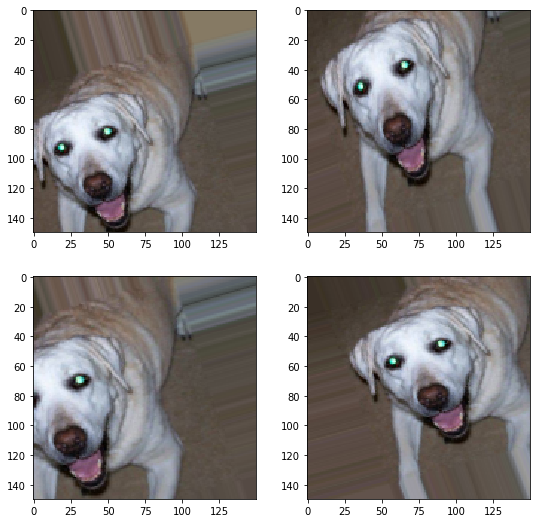

In [42]:
from keras.preprocessing import image

x = data_batch[1]
x = x.reshape((1,) + x.shape )

i = 0
plt.figure(figsize=(9,9))
for batch in datagen.flow(x, batch_size =1):
  plt.subplot(2,2,i+1)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
plt.show()

# Training a convolutional neural network with data augmentation and dropout layer (from page 141)

In [43]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
target_size = (150,150)


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    datpath_partial_train,
    target_size = target_size, 
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    datpath_validation,
    target_size = target_size,
    batch_size=batch_size,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [44]:
from keras import layers 
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [45]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50
)

model.save('model2_with_augmentation_and_dropout.h5')

Epoch 1/100
100/100 [==============================] - 39s 391ms/step - loss: 0.6937 - acc: 0.5134 - val_loss: 0.6862 - val_acc: 0.5393
Epoch 2/100
100/100 [==============================] - 36s 356ms/step - loss: 0.6860 - acc: 0.5469 - val_loss: 0.6696 - val_acc: 0.5651
Epoch 3/100
100/100 [==============================] - 36s 355ms/step - loss: 0.6745 - acc: 0.5844 - val_loss: 0.6550 - val_acc: 0.6288
Epoch 4/100
100/100 [==============================] - 36s 357ms/step - loss: 0.6581 - acc: 0.6066 - val_loss: 0.6378 - val_acc: 0.6269
Epoch 5/100
100/100 [==============================] - 34s 344ms/step - loss: 0.6506 - acc: 0.6209 - val_loss: 0.6622 - val_acc: 0.5990
Epoch 6/100
100/100 [==============================] - 37s 373ms/step - loss: 0.6415 - acc: 0.6344 - val_loss: 0.6316 - val_acc: 0.6353
Epoch 7/100
100/100 [==============================] - 36s 359ms/step - loss: 0.6366 - acc: 0.6431 - val_loss: 0.6112 - val_acc: 0.6720
Epoch 8/100
100/100 [===========================

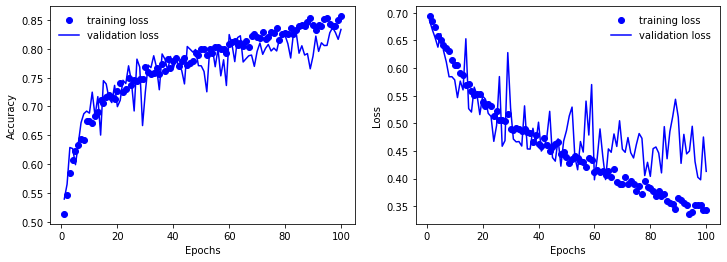

In [46]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label = 'training loss')
plt.plot(epochs, val_acc, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()

# Feature extraction (page 143)

In the technique of feature extraction, the representations learned by a previous network is used to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.  
  
At first, let us see the convolutional base of the VGG16, which is trained on ImageNet.

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
conv_base.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

The model defined in the previous cell (conv_base) will be extended by adding Dense layers.

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation=('sigmoid')))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has many parameters (14,714,668 parameters). Since this convolutional base is already trained, it will be frozen, which means it will not be trained. By freezing this convolutional base, only the Dense layers will be trained.  
  
In Keras, a network can be frozen by setting its trainable attribute to False.

In [0]:
print("The number of trainable weights before freezing the conv_base:", len(model.trainable_weights))

conv_base.trainable = False 

print("The number of trainable weights after freezing the conv_base:", len(model.trainable_weights))

The number of trainable weights before freezing the conv_base: 30
The number of trainable weights after freezing the conv_base: 4


Data augmentation will be performed for the training dataset.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20
target_size = (150,150)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    datpath_partial_train,
    target_size = target_size, 
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    datpath_validation,
    target_size = target_size,
    batch_size=batch_size,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
)

model.save('model3_transfer_learning.h5')

Epoch 1/30
100/100 [==============================] - 29s 288ms/step - loss: 0.6110 - acc: 0.6650 - val_loss: 0.4465 - val_acc: 0.8430
Epoch 2/30
100/100 [==============================] - 26s 260ms/step - loss: 0.4950 - acc: 0.7830 - val_loss: 0.3689 - val_acc: 0.8750
Epoch 3/30
100/100 [==============================] - 27s 268ms/step - loss: 0.4295 - acc: 0.8255 - val_loss: 0.3314 - val_acc: 0.8770
Epoch 4/30
100/100 [==============================] - 26s 264ms/step - loss: 0.4014 - acc: 0.8230 - val_loss: 0.3039 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 26s 263ms/step - loss: 0.3769 - acc: 0.8340 - val_loss: 0.2890 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 26s 263ms/step - loss: 0.3703 - acc: 0.8370 - val_loss: 0.2840 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 26s 262ms/step - loss: 0.3678 - acc: 0.8375 - val_loss: 0.2885 - val_acc: 0.8710
Epoch 8/30
100/100 [==============================] - 2

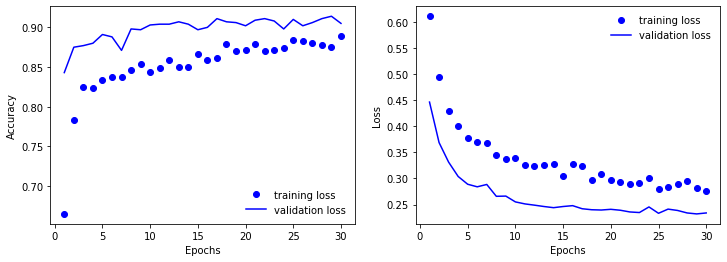

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label = 'training loss')
plt.plot(epochs, val_acc, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()

# Fine-tuning (from page 152)

During the fine tuning, a few of layers of a frozen model base are unfrozen and trained.

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20
target_size = (150,150)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    datpath_partial_train,
    target_size = target_size, 
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    datpath_validation,
    target_size = target_size,
    batch_size=batch_size,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

model.save('model4_fine_tuning.h5')

Epoch 1/50
100/100 [==============================] - 28s 276ms/step - loss: 0.2847 - acc: 0.8765 - val_loss: 0.2367 - val_acc: 0.9040
Epoch 2/50
100/100 [==============================] - 25s 253ms/step - loss: 0.2762 - acc: 0.8805 - val_loss: 0.2408 - val_acc: 0.8960
Epoch 3/50
100/100 [==============================] - 25s 252ms/step - loss: 0.2703 - acc: 0.8750 - val_loss: 0.2410 - val_acc: 0.9000
Epoch 4/50
100/100 [==============================] - 25s 252ms/step - loss: 0.2647 - acc: 0.8885 - val_loss: 0.2357 - val_acc: 0.9070
Epoch 5/50
100/100 [==============================] - 25s 252ms/step - loss: 0.2652 - acc: 0.8895 - val_loss: 0.2357 - val_acc: 0.9080
Epoch 6/50
100/100 [==============================] - 25s 252ms/step - loss: 0.2756 - acc: 0.8850 - val_loss: 0.2362 - val_acc: 0.9080
Epoch 7/50
100/100 [==============================] - 25s 250ms/step - loss: 0.2844 - acc: 0.8750 - val_loss: 0.2768 - val_acc: 0.8820
Epoch 8/50
100/100 [==============================] - 2

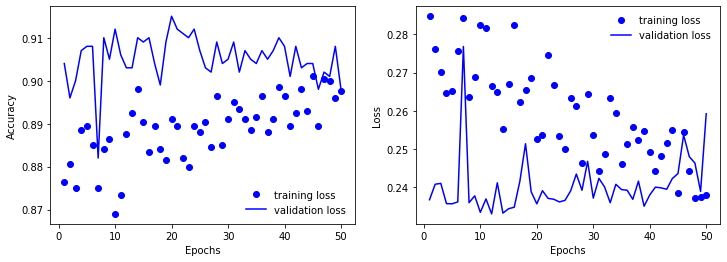

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label = 'training loss')
plt.plot(epochs, val_acc, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.legend(frameon = False)
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()